<a href="https://colab.research.google.com/github/VesalAhsani/Deep-learning-with-PyTorch/blob/main/04_PyTorch_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructor: Dr. Vesal Ahsani


# What is transfer learning?

**Transfer learning** allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

For example, we can take the patterns a computer vision model has learned from datasets such as [ImageNet](https://www.image-net.org/) (millions of images of different objects) and use them to power our food101 model.

*Transfer learning can be used for computer vision and NLP problems. In the case of computer vision, a computer vision model might learn patterns on millions of images in ImageNet and then use those patterns to infer on another problem. And for NLP, a language model may learn the structure of language by reading all of Wikipedia (and perhaps more) and then apply that knowledge to a different problem.*

### How can we find pretrained models

There are several places you can find pretrained models to use for your own problems.

| **Location** | **What's there?** | **Link(s)** | 
| ----- | ----- | ----- |
| **PyTorch domain libraries** | Each of the PyTorch domain libraries (`torchvision`, `torchtext`) come with pretrained models of some form. The models there work right within PyTorch. | [`torchvision.models`](https://pytorch.org/vision/stable/models.html), [`torchtext.models`](https://pytorch.org/text/main/models.html), [`torchaudio.models`](https://pytorch.org/audio/stable/models.html), [`torchrec.models`](https://pytorch.org/torchrec/torchrec.models.html) |
| **HuggingFace Hub** | A series of pretrained models on many different domains (vision, text, audio and more) from organizations around the world. There's plenty of different datasets too. | https://huggingface.co/models, https://huggingface.co/datasets | 
| **`timm` (PyTorch Image Models) library** | Almost all of the latest and greatest computer vision models in PyTorch code as well as plenty of other helpful computer vision features. | https://github.com/rwightman/pytorch-image-models|
| **Paperswithcode** | A collection of the latest state-of-the-art machine learning papers with code implementations attached. You can also find benchmarks here of model performance on different tasks. | https://paperswithcode.com/ | 


> So, in this notebook, we're going to train our previous data food101 via transfer learning to see whether its performance would improve...

## 1. Data

In [1]:
# download zip file from our github
from pathlib import Path
data_dir = Path("data/").mkdir(parents=True, exist_ok=True)

with open("data/food101_pizza_steak_sushi.zip", "wb") as f:
  import requests
  request = requests.get("https://github.com/VesalAhsani/Deep-learning-with-PyTorch/raw/main/data/food101_pizza_steak_sushi.zip")
  f.write(request.content)

import zipfile

with zipfile.ZipFile("data/food101_pizza_steak_sushi.zip", "r") as zipref:
  zipref.extractall("data/food101_pizza_steak_sushi")

In [2]:
# remove zip file
import os
os.remove("data/food101_pizza_steak_sushi.zip")

## 2. Datasets and DataLoaders

> **Note:** This notebook uses `torchvision`'s new [multi-weight support API (available in `torchvision` v0.13+)](https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/).

### Creating a transform for `torchvision.models` (auto creation)

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

Before, there was a way to manually create a transform for a pretrained model.

But as of `torchvision` v0.13+, an automatic transform creation feature has been added.

When you setup a model from `torchvision.models` and select the pretrained model weights you'd like to use, for example, say we'd like to use:
    
```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
```

Where,
* `EfficientNet_B0_Weights` is the model architecture weights we'd like to use (there are many differnt model architecture options in `torchvision.models`).
* `DEFAULT` means the *best available* weights (the best performance in ImageNet).
    * **Note:** Depending on the model architecture you choose, you may also see other options such as `IMAGENET_V1` and `IMAGENET_V2` where generally the higher version number the better. Though if you want the best available, `DEFAULT` is the easiest option. See the [`torchvision.models` documentation](https://pytorch.org/vision/main/models.html) for more.

> The benefit of automatically creating a transform through weights.transforms() is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

Let's try it out.

In [3]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dir = "data/food101_pizza_steak_sushi/train"
test_dir = "data/food101_pizza_steak_sushi/test"

# Auto-transform: 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transform = weights.transforms()

train_dataset = datasets.ImageFolder(root=train_dir, transform=auto_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=auto_transform)

train_dataloader = DataLoader(dataset=train_dataset,
                             batch_size=32,
                             shuffle=True,
                             num_workers=1)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=1)

And to access the transforms assosciated with our `weights`, we can use the `transforms()` method.

This is essentially saying "get the data transforms that were used to train the `EfficientNet_B0_Weights` on ImageNet".

## 3. Getting a pre-trained model

The whole idea of transfer learning is to **take an already well-performing model on a problem-space similar to yours and then customising it to your use case**.

Since we're working on a computer vision problem (image classification with Food101 data), we can find pretrained classification models in [`torchvision.models`](https://pytorch.org/vision/stable/models.html#classification).

Exploring the documentation, you'll find plenty of common computer vision architecture backbones such as:

| **Architecuture backbone** | **Code** |
| ----- | ----- |
| [ResNet](https://arxiv.org/abs/1512.03385)'s | `torchvision.models.resnet18()`, `torchvision.models.resnet50()`... | 
| [VGG](https://arxiv.org/abs/1409.1556) (similar to what we used for TinyVGG) | `torchvision.models.vgg16()` | 
| [EfficientNet](https://arxiv.org/abs/1905.11946)'s | `torchvision.models.efficientnet_b0()`, `torchvision.models.efficientnet_b1()`... | 
| [VisionTransformer](https://arxiv.org/abs/2010.11929) (ViT's)| `torchvision.models.vit_b_16()`, `torchvision.models.vit_b_32()`... | 
| [ConvNeXt](https://arxiv.org/abs/2201.03545) | `torchvision.models.convnext_tiny()`,  `torchvision.models.convnext_small()`... |
| More available in `torchvision.models` | `torchvision.models...` |

> The pretrained model we're going to be using is [`torchvision.models.efficientnet_b0()`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0).

The architecture is from the paper *[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)*.


We can setup the `EfficientNet_B0` pretrained ImageNet weights using the same code as we used to create the transforms.


```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights for ImageNet
```

> Generally, the higher number in the model name (e.g. `efficientnet_b0()` -> `efficientnet_b1()` -> `efficientnet_b7()`) means *better performance* but a *larger* model.

> Understanding this **performance vs. speed vs. size tradeoff** will come with time and practice.


Our `efficientnet_b0` comes in three main parts:
1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as **features** or **feature extractor**, "the base layers of the model learn the different **features** of images").
2. `avgpool` - Takes the average of the output of the `features` layer(s) and turns it into a **feature vector**.
3. `classifier` - Turns the **feature vector** into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and because ImageNet has 1000 classes, `out_features=1000` is the default). 

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b0(weights = weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

To learn more about our model, let's use `torchinfo`'s [`summary()` method](https://github.com/TylerYep/torchinfo#documentation).

To do so, we'll pass in:
 * `model` - the model we'd like to get a summary of.
 * `input_size` - the shape of the data we'd like to pass to our model, for the case of `efficientnet_b0`, the input size is `(batch_size, 3, 224, 224)`, though [other variants of `efficientnet_bX` have different input sizes](https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93).
    * **Note:** Many modern models can handle input images of varying sizes thanks to [`torch.nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html), this layer adaptively adjusts the `output_size` of a given input as required. You can try this out by passing different size input images to `summary()` or your models.
 * `col_names` - the various information columns we'd like to see about our model. 
 * `col_width` - how wide the columns should be for the summary.
 * `row_settings` - what features to show in a row.

In [6]:
!pip install torchinfo
import torchinfo
from torchinfo import summary

summary(model=model_1,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

> You can customise the outputs of a pretrained model by changing the output layer(s) to suit your problem. The original `torchvision.models.efficientnet_b0()` comes with `out_features=1000` because there are 1000 classes in ImageNet, the dataset it was trained on. However, for our problem, classifying images of pizza, steak and sushi we only need `out_features=3`.

Let's freeze all of the layers/parameters in the `features` section of our `efficientnet_b0` model.

> **Note:** To *freeze* layers means to keep them how they are during training. For example, if your model has pretrained layers, to *freeze* them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.

> We'll keep the `Dropout` layer the same using [`torch.nn.Dropout(p=0.2, inplace=True)`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

> **Note:** [Dropout layers](https://developers.google.com/machine-learning/glossary#dropout_regularization) randomly remove connections between two neural network layers with a probability of `p`. For example, if `p=0.2`, 20% of connections between neural network layers will be removed at random each pass. This practice is meant to help regularize (prevent overfitting) a model by making sure the connections that remain learn features to compensate for the removal of the other connections (hopefully these remaining features are *more general*). 

In [7]:
# Freeze
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for param in model_1.features.parameters():
  param.requires_grad = False

model_1.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=3,
              bias=True)
).to(device)

In [8]:
# Let's take a look at the summary again!
summary(model=model_1,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train the model

In [9]:
!pip install torchmetrics
import torchmetrics
from torchmetrics import Accuracy

acc = Accuracy().to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 9.0 MB/s 


In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr=0.001)

In [11]:
from torch.utils import data

def train_step(model, dataloader, loss_fn, accuracy_fn, optimizer, device):
  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

def test_step(model, dataloader, loss_fn, accuracy_fn, device):
  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(test_pred, y)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

def train(model, train_dataloader, test_dataloader, loss_fn, accuracy_fn, optimizer, epochs, device):
  from tqdm.auto import tqdm
  results = {"train_loss" : [],
             "train_acc" : [],
             "test_loss" : [],
             "test_acc" : []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model_1,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       accuracy_fn=acc,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model_1,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       accuracy_fn=acc,
                                       device=device)
    
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    print(f"Epoch: {epoch+1} | train_loss: {train_loss:.5f} train_acc: {train_acc:.2f}% | test_loss: {test_loss:.5f} test_acc: {test_acc:.2f}%")

  return results


In [20]:
from timeit import default_timer as timer
start_time = timer()
results = train(model_1, train_dataloader, test_dataloader, loss_fn, acc, optimizer, 4,device)
end_time = timer()
print(f"total training time: {end_time - start_time} seconds")

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.61840 train_acc: 0.78% | test_loss: 0.59660 test_acc: 0.85%
Epoch: 2 | train_loss: 0.58732 train_acc: 0.80% | test_loss: 0.61313 test_acc: 0.86%
Epoch: 3 | train_loss: 0.54252 train_acc: 0.80% | test_loss: 0.51235 test_acc: 0.87%
Epoch: 4 | train_loss: 0.51277 train_acc: 0.79% | test_loss: 0.47890 test_acc: 0.89%
total training time: 12.247860924999998 seconds


> With an `efficientnet_b0` backbone, our model achieves almost 90% accuracy on the test dataset, almost *double* what we were able to achieve with TinyVGG.


## 5. Plot loss curves

In [21]:
results["train_loss"][0].cpu().detach().numpy().item()

0.6183955073356628

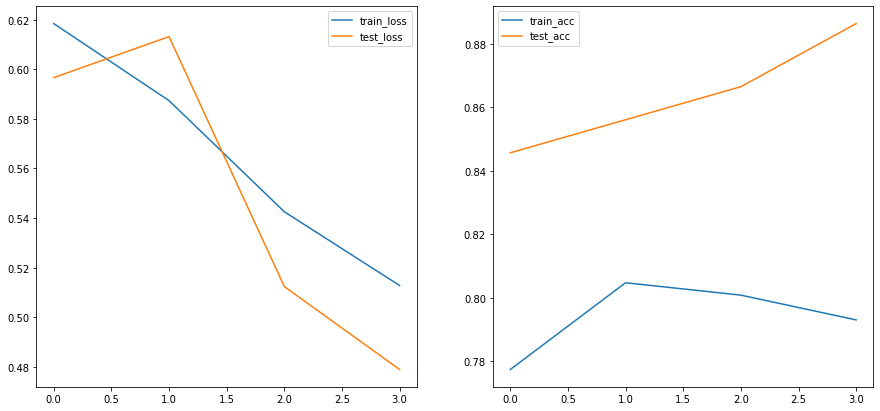

In [22]:
# Let's plot loss curves
import matplotlib.pyplot as plt
import numpy as np

train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]
for i in range(len(results["train_loss"])):
  tr_loss = results["train_loss"][i].cpu().detach().numpy().item()
  tr_acc = results["train_acc"][i].cpu().detach().numpy().item()
  te_loss = results["test_loss"][i].cpu().detach().numpy().item()
  te_acc = results["test_acc"][i].cpu().detach().numpy().item()

  train_loss.append(tr_loss)
  train_acc.append(tr_acc)
  test_loss.append(te_loss)
  test_acc.append(te_acc)

epochs = range(len(results["train_loss"]))

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label = "train_loss")
plt.plot(epochs, test_loss, label = "test_loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label = "train_acc")
plt.plot(epochs, test_acc, label = "test_acc")
plt.legend();

## 6. Make some predictions


One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in *same* format as the images our model was trained on.

This means we'll need to make sure our images have:
* **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
* **Same datatype** - If our images are a different datatype (e.g. `torch.int8` vs. `torch.float32`) we'll get datatype errors.
* **Same device** - If our images are on a different device to our model, we'll get device errors.
* **Same transformations** - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make preidctions on images transformed in a different way, these predictions may be off.

> **Note:** These requirements go for all kinds of data if you're trying to make predictions with a trained model. Data you'd like to predict on should be in the same format as your model was trained on.


In [23]:
import random
from PIL import Image

def pred_and_plot(model, image, transform, device):

  img = Image.open(image)
  class_names= train_dataset.classes
  model.eval()
  with torch.inference_mode():
    y_logit = model(transform(img).unsqueeze(dim=0).to(device))
    y_pred = torch.softmax(y_logit, dim=1)
    y_prob = torch.argmax(y_pred)
  
  plt.figure()
  plt.imshow(img)
  plt.title(f"prediction: {class_names[y_prob]} | prob: {y_pred.max()}")
  plt.axis(False)

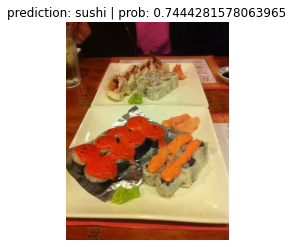

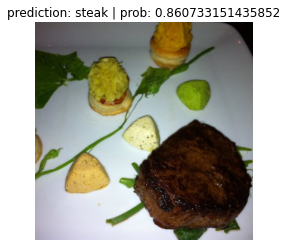

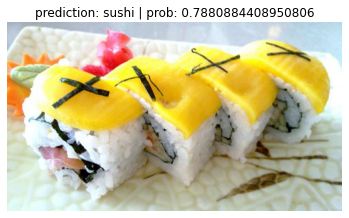

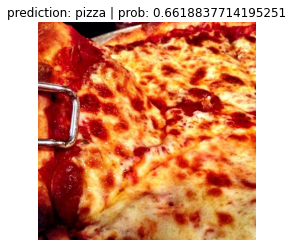

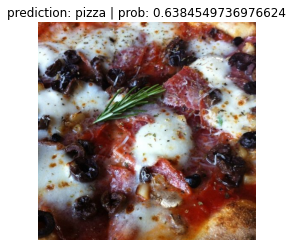

In [24]:
image_path = list(Path(test_dir).glob("*/*.jpg"))
image_samples = random.sample(image_path,k=5 )

for image in image_samples:
  pred_and_plot(model=model_1,
                image=image,
                transform=auto_transform,
                device=device)

## 7. Make prediction on a custom image

> Let's make prediction on an image I've taken with my Iphone !

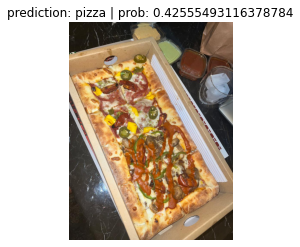

In [25]:
with open("data/custom.jpeg", "wb") as f:
  import requests
  request = requests.get("https://github.com/VesalAhsani/Deep-learning-with-PyTorch/raw/main/data/custom.jpeg")
  f.write(request.content)

pred_and_plot(model=model_1,
              image="data/custom.jpeg",
              transform=auto_transform,
              device=device)

Perfect !!
It could predict pretty well! 